In [1]:
import os
import re
import gc
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer

os.environ["TOKENIZERS_PARALLELISM"] = "false"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

2026-01-27 11:53:49.094774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769514829.287157      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769514829.341457      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769514829.782622      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769514829.782663      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769514829.782665      55 computation_placer.cc:177] computation placer alr

Using Device: cuda


In [2]:
MODEL_NAME = "CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment"
OUTPUT_DIR = '/kaggle/working/'

train_path = '/kaggle/input/nlpassignments/AraSenti_all.xlsx' 
test_path = '/kaggle/input/nlpassignments/HIAQatar_tweets.xlsx'

def clean_tweet(tweet):
    tweet = str(tweet)
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'[@#]\w+', '', tweet)
    tweet = re.sub(r'[a-zA-Z0-9]', '', tweet)
    tweet = re.sub(r'_', '', tweet)
    tweet = re.sub(r'(.)\1+', r'\1', tweet)
    tweet = re.sub(r'[إأآا]', 'ا', tweet)
    tweet = re.sub(r'ة', 'ه', tweet)
    tweet = re.sub(r'ى', 'ي', tweet)
    tweet = re.sub(r'[^\w\s\u0600-\u06FF]', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

print("Loading datasets")
df_train = pd.read_excel(train_path)
df_test = pd.read_excel(test_path)

print(f"Original training samples: {len(df_train)}")
print(f"Original testing samples: {len(df_test)}")

df_train['clean_tweet'] = df_train['tweet'].apply(clean_tweet)
df_test['clean_tweet'] = df_test['tweet'].apply(clean_tweet)

df_train = df_train[df_train['clean_tweet'].str.len() > 0].reset_index(drop=True)
df_test = df_test[df_test['clean_tweet'].str.len() > 0].reset_index(drop=True)

print(f"Cleaned training samples: {len(df_train)}")
print(f"Cleaned testing samples: {len(df_test)}")

Loading datasets
Original training samples: 15751
Original testing samples: 151
Cleaned training samples: 15751
Cleaned testing samples: 151


In [3]:
print("Extracting Word Embeddings from CAMeL-BERT")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)

def get_word_embeddings(texts, batch_size=32, max_length=60):
    bert_model.eval()
    all_embeddings = []
    
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            inputs = tokenizer(
                batch_texts, 
                return_tensors='pt', 
                padding='max_length', 
                truncation=True, 
                max_length=max_length
            ).to(DEVICE)
            
            outputs = bert_model(**inputs)
            embeddings = outputs.last_hidden_state.cpu()
            all_embeddings.append(embeddings)
            
            if (i // batch_size) % 20 == 0:
                print(f"Processed {min(i+batch_size, len(texts))}/{len(texts)}")
    
    return torch.cat(all_embeddings, dim=0)

X_train_seq = get_word_embeddings(df_train['clean_tweet'].tolist())
X_test_seq = get_word_embeddings(df_test['clean_tweet'].tolist())
y_train_tensor = torch.tensor(df_train['label'].values)
y_test_tensor = torch.tensor(df_test['label'].values)

del bert_model
gc.collect()
torch.cuda.empty_cache()

print(f"Embeddings shape: {X_train_seq.shape}")

Extracting Word Embeddings from CAMeL-BERT


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Processed 32/15751
Processed 672/15751
Processed 1312/15751
Processed 1952/15751
Processed 2592/15751
Processed 3232/15751
Processed 3872/15751
Processed 4512/15751
Processed 5152/15751
Processed 5792/15751
Processed 6432/15751
Processed 7072/15751
Processed 7712/15751
Processed 8352/15751
Processed 8992/15751
Processed 9632/15751
Processed 10272/15751
Processed 10912/15751
Processed 11552/15751
Processed 12192/15751
Processed 12832/15751
Processed 13472/15751
Processed 14112/15751
Processed 14752/15751
Processed 15392/15751
Processed 32/151
Embeddings shape: torch.Size([15751, 60, 768])


In [4]:
dataset_full = TensorDataset(X_train_seq, y_train_tensor)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
train_idx, val_idx = next(sss.split(X_train_seq, y_train_tensor))

train_data = torch.utils.data.Subset(dataset_full, train_idx)
val_data = torch.utils.data.Subset(dataset_full, val_idx)

print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(TensorDataset(X_test_seq, y_test_tensor), batch_size=32)

Training samples: 13388, Validation samples: 2363


In [14]:
class BiLSTMSentiment(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=128, num_classes=3, num_layers=1, dropout=0.5):
        super(BiLSTMSentiment, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        
    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x.float())
        hidden_last_fwd = hidden[-2]
        hidden_last_bwd = hidden[-1]
        hidden_concat = torch.cat((hidden_last_fwd, hidden_last_bwd), dim=1)
        hidden_concat = self.dropout(hidden_concat)
        output = self.fc(hidden_concat)
        return output

In [15]:
def train_bilstm(model, train_loader, val_loader, epochs=30, patience=5):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, average='macro')
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        scheduler.step(avg_val_loss)
        
        print(f"Epoch [{epoch+1:02d}/{epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    model.load_state_dict(best_model_state)
    return model, history

In [16]:
bilstm_model = BiLSTMSentiment().to(DEVICE)
print("Training BiLSTM")
bilstm_model, history = train_bilstm(bilstm_model, train_loader, val_loader)

bilstm_model.eval()
y_true_b = []
y_pred_b = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(DEVICE)
        outputs = bilstm_model(batch_x)
        _, predicted = torch.max(outputs, 1)
        y_pred_b.extend(predicted.cpu().numpy())
        y_true_b.extend(batch_y.numpy())

acc_bilstm = accuracy_score(y_true_b, y_pred_b)
f1_bilstm = f1_score(y_true_b, y_pred_b, average='macro')

print(f"BiLSTM Results on Airport Dataset:")
print(f"Accuracy: {acc_bilstm:.4f}")
print(f"F1 Score (Macro): {f1_bilstm:.4f}")
print("Classification Report:")
print(classification_report(y_true_b, y_pred_b, target_names=['Negative', 'Positive', 'Neutral']))

Training BiLSTM
Epoch [01/30] Train Loss: 0.5516 | Val Loss: 0.5147 | Val Acc: 0.8781 | Val F1: 0.8775
Epoch [02/30] Train Loss: 0.5005 | Val Loss: 0.4912 | Val Acc: 0.8887 | Val F1: 0.8888
Epoch [03/30] Train Loss: 0.4773 | Val Loss: 0.4864 | Val Acc: 0.8963 | Val F1: 0.8964
Epoch [04/30] Train Loss: 0.4539 | Val Loss: 0.4959 | Val Acc: 0.8950 | Val F1: 0.8949
Epoch [05/30] Train Loss: 0.4385 | Val Loss: 0.4802 | Val Acc: 0.8984 | Val F1: 0.8981
Epoch [06/30] Train Loss: 0.4181 | Val Loss: 0.4936 | Val Acc: 0.8946 | Val F1: 0.8945
Epoch [07/30] Train Loss: 0.4033 | Val Loss: 0.4972 | Val Acc: 0.8950 | Val F1: 0.8948
Epoch [08/30] Train Loss: 0.3838 | Val Loss: 0.4951 | Val Acc: 0.8980 | Val F1: 0.8983
Epoch [09/30] Train Loss: 0.3721 | Val Loss: 0.5019 | Val Acc: 0.8993 | Val F1: 0.8993
Epoch [10/30] Train Loss: 0.3463 | Val Loss: 0.4973 | Val Acc: 0.8993 | Val F1: 0.8990
Early stopping at epoch 10
BiLSTM Results on Airport Dataset:
Accuracy: 0.7616
F1 Score (Macro): 0.7464
Classifica

In [49]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_train['clean_tweet'].tolist(),
    df_train['label'].values,
    test_size=0.15,
    random_state=42,
    stratify=df_train['label'].values
)

class LLMSet(Dataset):
    def __init__(self, texts, labels, max_length=60):
        self.enc = tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.enc.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

train_ds = LLMSet(train_texts, train_labels)
val_ds = LLMSet(val_texts, val_labels)
test_ds = LLMSet(df_test['clean_tweet'].tolist(), df_test['label'].values)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'f1': f1, 'f1_macro': f1}

In [ ]:
best_f1_llm = 0
best_path = 'best_llm_model'

for lr in [2e-5, 3e-5]:
    for epoch in [3, 4]:
        print(f"Training with LR={lr}, Epochs={epoch}")
        model_llm = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3).to(DEVICE)
        
        args = TrainingArguments(
            output_dir=OUTPUT_DIR,
            num_train_epochs=epoch,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            learning_rate=lr,
            weight_decay=0.01,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            greater_is_better=True,
            report_to="none",
            save_total_limit=1,
            label_smoothing_factor=0.1,
        )
        
        trainer = Trainer(
            model_llm,
            args,
            train_dataset=train_ds,
            eval_dataset=val_ds,
            processing_class=tokenizer,
            compute_metrics=compute_metrics
        )
        
        trainer.train()
        res = trainer.evaluate()
        current_f1 = res['eval_f1_macro']
        print(f"Validation F1: {current_f1:.4f}")
        
        if current_f1 > best_f1_llm:
            best_f1_llm = current_f1
            trainer.save_model(best_path)
            print("New best model saved")
        
        del model_llm
        gc.collect()
        torch.cuda.empty_cache()

Training with LR=2e-05, Epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,0.550300,0.440600,0.927211,0.927470,0.927470
2,0.374400,0.449174,0.928058,0.928152,0.928152
3,0.332600,0.455891,0.924249,0.924428,0.924428


Validation F1: 0.9282
New best model saved
Training with LR=2e-05, Epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,0.550200,0.441029,0.925518,0.925774,0.925774
2,0.375700,0.451455,0.926365,0.926485,0.926485
3,0.334600,0.459249,0.925942,0.925893,0.925893
4,0.310000,0.464298,0.928058,0.928175,0.928175


Validation F1: 0.9282
New best model saved
Training with LR=3e-05, Epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,0.537000,0.447857,0.922556,0.922987,0.922987
2,0.371000,0.452498,0.923826,0.924165,0.924165
3,0.328500,0.456502,0.928058,0.928387,0.928387


Validation F1: 0.9284
New best model saved
Training with LR=3e-05, Epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,0.537500,0.453448,0.918747,0.919382,0.919382
2,0.373200,0.459506,0.920440,0.920765,0.920765
3,0.330600,0.467457,0.928481,0.928854,0.928854
4,0.310200,0.466288,0.928058,0.928395,0.928395


Validation F1: 0.9289
New best model saved


In [55]:
print("Loading best LLM model")
final_model = AutoModelForSequenceClassification.from_pretrained(best_path).to(DEVICE)
final_trainer = Trainer(
    final_model,
    args=TrainingArguments(output_dir='./final', report_to="none"),
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

preds = final_trainer.predict(test_ds)
y_pred_llm = preds.predictions.argmax(-1)
y_true_llm = preds.label_ids

acc_llm = accuracy_score(y_true_llm, y_pred_llm)
f1_llm = f1_score(y_true_llm, y_pred_llm, average='macro')

print(f"LLM Results on Airport Dataset:")
print(f"Accuracy: {acc_llm:.4f}")
print(f"F1 Score (Macro): {f1_llm:.4f}")
print("Classification Report:")
print(classification_report(y_true_llm, y_pred_llm, target_names=['Negative', 'Positive', 'Neutral']))

Loading best LLM model


LLM Results on Airport Dataset:
Accuracy: 0.7550
F1 Score (Macro): 0.7407
Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.68      0.80        82
    Positive       0.68      0.85      0.76        40
     Neutral       0.56      0.83      0.67        29

    accuracy                           0.75       151
   macro avg       0.73      0.79      0.74       151
weighted avg       0.81      0.75      0.76       151



FINAL COMPARISON REPORT
Model                     Accuracy     F1 Score    
------------------------------------------------------------
BiLSTM                    0.7417       0.7279      
Fine-tuned LLM            0.7550       0.7407      


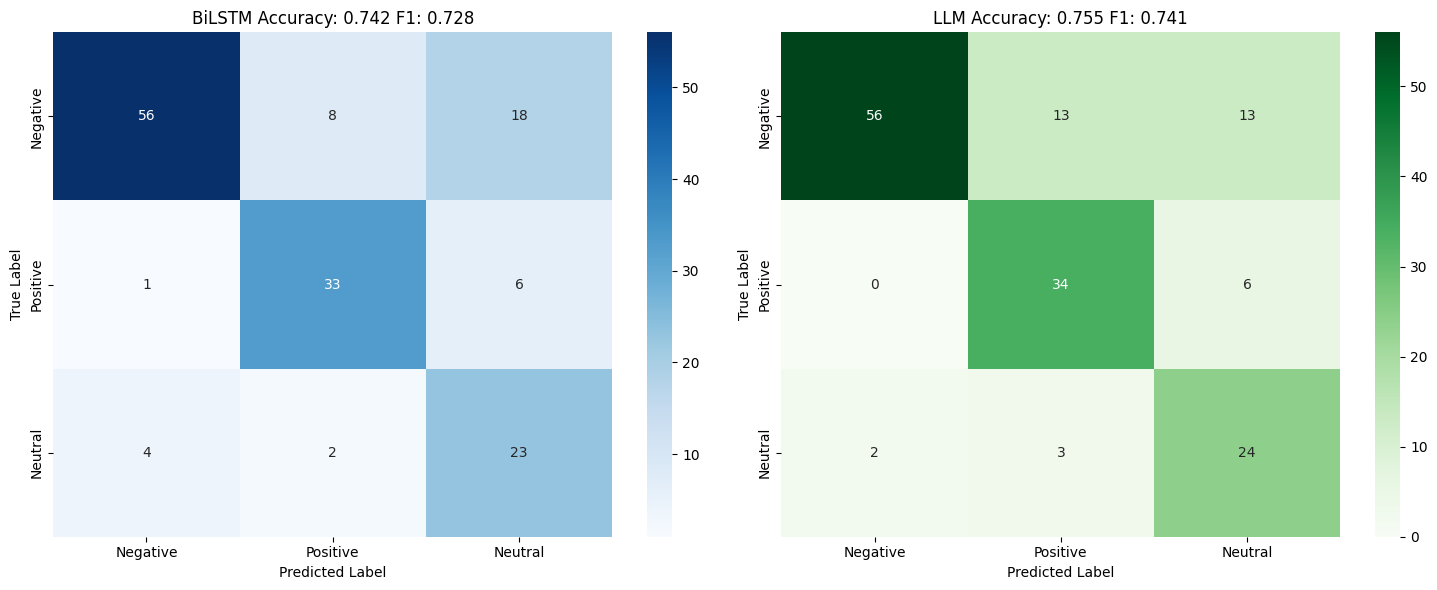

In [56]:
print("FINAL COMPARISON REPORT")
print(f"{'Model':<25} {'Accuracy':<12} {'F1 Score':<12}")
print("-" * 60)
print(f"{'BiLSTM':<25} {acc_bilstm:<12.4f} {f1_bilstm:<12.4f}")
print(f"{'Fine-tuned LLM':<25} {acc_llm:<12.4f} {f1_llm:<12.4f}")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

cm_bilstm = confusion_matrix(y_true_b, y_pred_b)
sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Negative', 'Positive', 'Neutral'],
            yticklabels=['Negative', 'Positive', 'Neutral'])
axes[0].set_title(f'BiLSTM Accuracy: {acc_bilstm:.3f} F1: {f1_bilstm:.3f}')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

cm_llm = confusion_matrix(y_true_llm, y_pred_llm)
sns.heatmap(cm_llm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Negative', 'Positive', 'Neutral'],
            yticklabels=['Negative', 'Positive', 'Neutral'])
axes[1].set_title(f'LLM Accuracy: {acc_llm:.3f} F1: {f1_llm:.3f}')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

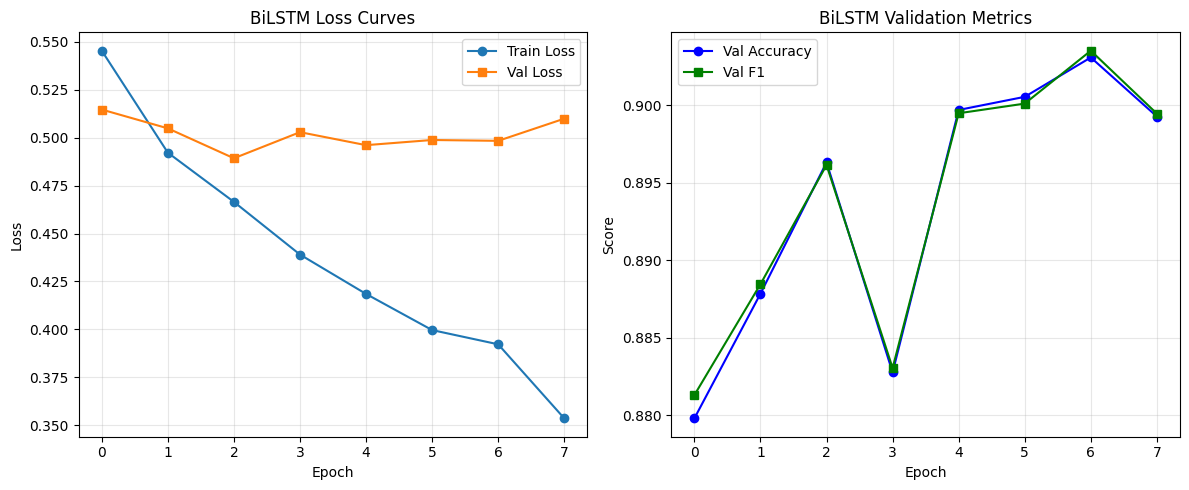

In [58]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.title('BiLSTM Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Val Accuracy', marker='o', color='blue')
plt.plot(history['val_f1'], label='Val F1', marker='s', color='green')
plt.title('BiLSTM Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

